<a href="https://colab.research.google.com/github/S-HATANO1970/otemae/blob/main/%E6%83%85%E5%A0%B1%E6%B4%BB%E7%94%A82_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

下記コードを先に実行する

In [ ]:
!pip install japanize-matplotlib
import japanize_matplotlib

# GANモデルを使用した画像生成AIシステム
shape_typeを変更すると生成する画像が変えられます。
* 正方形:square
* 長方形:rectangle
* 円:circle
* 三角形:triangle
* 縦線:virtical
* 横線:horizontal
* 斜め線:diagonal

🎓 画像生成AI学習システム
受講者向け：超シンプル版

🤖 画像生成AI学習システム開始！
📊 学習用の図形データを作成中...


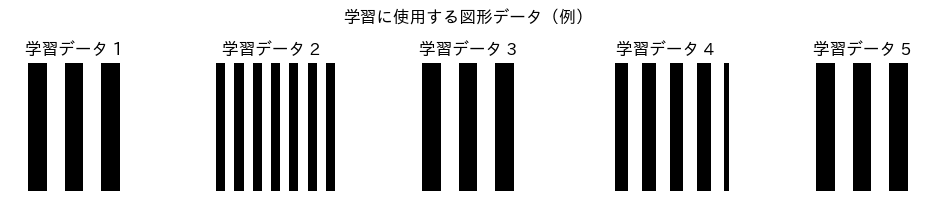

🎯 設定パラメータ:
   ノイズ次元数: 1
   学習率: 0.0002
   バッチサイズ: 64

🎲 学習前の生成画像（ランダムノイズ）:


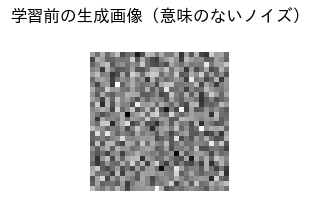

🚀 学習開始（20エポック）...
エポック   2/20 | D損失: 0.1277 | G損失: 3.3374
エポック   4/20 | D損失: 0.0088 | G損失: 5.9501
エポック   6/20 | D損失: 0.0107 | G損失: 5.8804
エポック   8/20 | D損失: 0.0067 | G損失: 6.3009
エポック  10/20 | D損失: 0.0023 | G損失: 6.9165
エポック  12/20 | D損失: 0.0016 | G損失: 7.1891
エポック  14/20 | D損失: 0.0015 | G損失: 7.5642
エポック  16/20 | D損失: 0.0037 | G損失: 6.7402
エポック  18/20 | D損失: 0.0327 | G損失: 5.7772
エポック  20/20 | D損失: 0.0131 | G損失: 6.4900
✅ 学習完了！


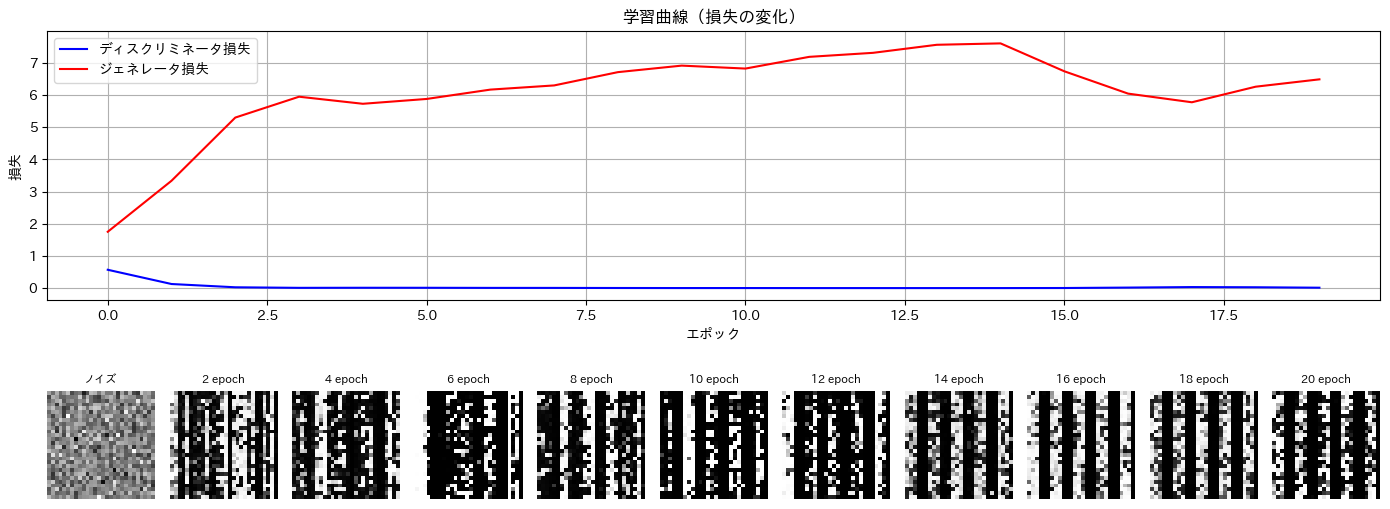


🔬 パラメータ実験モード
異なるパラメータでの学習結果を比較します

📈 学習率 1e-05 での実験中...
📈 学習率 0.0002 での実験中...
📈 学習率 0.005 での実験中...


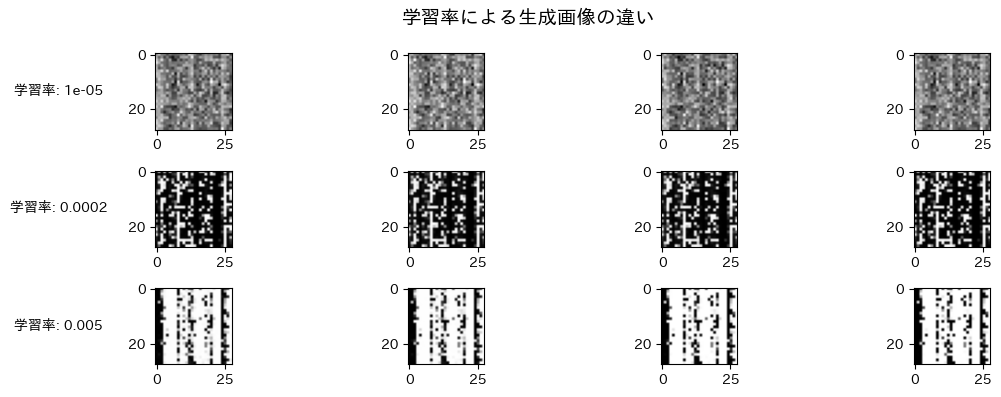

💡 観察ポイント:
   - 学習率が高い → 学習は速いが不安定になりやすい
   - 学習率が低い → 安定だが学習が遅い
   - 適切なバランスが重要！

🎉 すべての実験が完了しました！

💡 学習のポイント:
   1. ジェネレータとディスクリミネータが競争しながら学習
   2. パラメータ調整で結果が大きく変わる
   3. 学習の安定性と品質のバランスが重要
   4. 実際のAI開発でも同様の原理が使われている


In [2]:
# 超シンプルな画像生成AI学習システム

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Any

# ========================================
# 1. 学習用データの作成
# ========================================

def create_simple_shapes(num_samples:int=1000, img_size:int=28) -> np.ndarray:
    """
    シンプルな画像データを作成
    """
    images = []

    for _ in range(num_samples):
        # 28x28の黒い画像を作成
        img = np.zeros((img_size, img_size))

        # 図形を選択
        shape_type = 'vertical'
        # shape_type = np.random.choice(['square','circle','triangle'])
        # shape_type = np.random.choice(['horizontal','vertical','diagonal'])

        # 図形のサイズと位置をランダムに決定
        size = np.random.randint(10, 12)  # サイズを小さめに調整
        margin = size // 2 + 1  # 境界からの余白
        center_x = np.random.randint(margin, img_size - margin)
        center_y = np.random.randint(margin, img_size - margin)
        stripe_width = np.random.randint(2, 6)

        if shape_type == 'square':
            # 四角形を描画
            img[center_y-size//2:center_y+size//2,
                center_x-size//2:center_x+size//2] = 1.0

        elif shape_type == 'rectangle':
            # 四角形を描画
            img[center_y-size//2:center_y+size,
                center_x-size//2:center_x+size//2] = 1.0

        elif shape_type == 'circle':
            # 円を描画
            y, x = np.ogrid[:img_size, :img_size]
            mask = (x - center_x)**2 + (y - center_y)**2 <= (size//2)**2
            img[mask] = 1.0

        elif shape_type == 'triangle':
            # 三角形を描画（簡易版）
            for i in range(size):
                start = center_x - i//2
                end = center_x + i//2 + 1
                y_pos = center_y - size//2 + i
                if 0 <= y_pos < img_size:
                    img[y_pos, max(0, start):min(img_size, end)] = 1.0

        elif shape_type == 'horizontal':
            # 横縞パターン
            for y in range(img_size):
                if (y // stripe_width) % 2 == 0:
                    img[y, :] = 1.0

        elif shape_type == 'vertical':
            # 縦縞パターン
            for x in range(img_size):
                if (x // stripe_width) % 2 == 0:
                    img[:, x] = 1.0

        elif shape_type == 'diagonal':
            # 斜め縞パターン
            for y in range(img_size):
                for x in range(img_size):
                    if ((x + y) // stripe_width) % 2 == 0:
                        img[y, x] = 1.0
        images.append(img)

    return np.array(images)

# ========================================
# 2. AIのネットワーク構造定義
# ========================================

class Generator(nn.Module):
    """
    ジェネレータ：ランダムノイズから画像を生成するAI
    """
    def __init__(self, noise_dim:int=100, img_dim:int=784) -> None:  # 28x28 = 784
        super(Generator, self).__init__()

        # シンプルな3層構造
        self.net = nn.Sequential(
            # ノイズ → 128次元
            nn.Linear(noise_dim, 128),
            nn.ReLU(),

            # 128次元 → 256次元
            nn.Linear(128, 256),
            nn.ReLU(),

            # 256次元 → 画像サイズ（784次元）
            nn.Linear(256, img_dim),
            nn.Sigmoid()  # 0-1の範囲に正規化
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class Discriminator(nn.Module):
    """
    ディスクリミネータ：画像が本物か偽物かを判定するAI
    """
    def __init__(self, img_dim:int=784) -> None:  # 28x28 = 784
        super(Discriminator, self).__init__()

        # シンプルな3層構造
        self.net = nn.Sequential(
            # 画像（784次元） → 256次元
            nn.Linear(img_dim, 256),
            nn.LeakyReLU(0.2),

            # 256次元 → 128次元
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),

            # 128次元 → 1次元（本物か偽物かの判定）
            nn.Linear(128, 1),
            nn.Sigmoid()  # 0-1の確率値
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

# ========================================
# 3. 学習可能なパラメータ設定
# ========================================

class GANTrainer:
    def __init__(self):
        # 【受講者が変更可能なパラメータ】
        self.noise_dim = 1        # ノイズの次元数（大きいほど多様性↑）
        self.learning_rate = 0.0002 # 学習率（大きいほど学習速度↑、不安定になりやすい）
        self.batch_size = 64        # バッチサイズ（大きいほど安定、メモリ使用量↑）

        # AIネットワークを初期化
        self.generator = Generator(self.noise_dim)
        self.discriminator = Discriminator()

        # 最適化アルゴリズム（Adam）を設定
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=self.learning_rate)
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=self.learning_rate)

        # 損失関数（二値交差エントロピー）
        self.criterion = nn.BCELoss()

        # 学習過程を記録
        self.initial_samples: Optional[np.ndarray] = None
        self.g_losses = []
        self.d_losses = []
        self.generated_images = []

    def train_step(self, real_images: torch.Tensor) -> tuple:
        """
        1回の学習ステップ
        """
        batch_size = real_images.size(0)

        # ラベル作成（本物=1、偽物=0）
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # ========================================
        # ディスクリミネータの学習
        # ========================================

        # 本物画像での学習
        real_outputs = self.discriminator(real_images)
        d_loss_real = self.criterion(real_outputs, real_labels)

        # 偽物画像を生成
        noise = torch.randn(batch_size, self.noise_dim)
        fake_images = self.generator(noise)

        # 偽物画像での学習
        fake_outputs = self.discriminator(fake_images.detach())
        d_loss_fake = self.criterion(fake_outputs, fake_labels)

        # ディスクリミネータの総損失
        d_loss = d_loss_real + d_loss_fake

        # パラメータ更新
        self.d_optimizer.zero_grad()
        d_loss.backward()
        self.d_optimizer.step()

        # ========================================
        # ジェネレータの学習
        # ========================================

        # 新しいノイズで偽物画像を生成
        noise = torch.randn(batch_size, self.noise_dim)
        fake_images = self.generator(noise)

        # ディスクリミネータに偽物を「本物」として騙せるかテスト
        fake_outputs = self.discriminator(fake_images)
        g_loss = self.criterion(fake_outputs, real_labels)  # 本物ラベルで学習

        # パラメータ更新
        self.g_optimizer.zero_grad()
        g_loss.backward()
        self.g_optimizer.step()

        return d_loss.item(), g_loss.item()

    def generate_sample(self, num_samples:int=16) -> np.ndarray:
        """
        サンプル画像を生成
        """
        with torch.no_grad():
            noise = torch.randn(num_samples, self.noise_dim)
            fake_images = self.generator(noise)
            return fake_images.view(-1, 28, 28).numpy()

# ========================================
# 4. 実際の学習実行と可視化
# ========================================

def run_learning_experiment() -> GANTrainer:
    """
    学習実験を実行
    """
    print("🤖 画像生成AI学習システム開始！")
    print("=" * 50)

    # 1. 学習データを作成
    print("📊 学習用の図形データを作成中...")
    real_data = create_simple_shapes(num_samples=5000)
    real_tensor = torch.FloatTensor(real_data.reshape(-1, 784))

    # データの例を表示
    plt.figure(figsize=(10, 2))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(real_data[i], cmap='gray')
        plt.title(f'学習データ {i+1}')
        plt.axis('off')
    plt.suptitle('学習に使用する図形データ（例）')
    plt.tight_layout()
    plt.show()

    # 2. GANトレーナーを初期化
    trainer = GANTrainer()

    print(f"🎯 設定パラメータ:")
    print(f"   ノイズ次元数: {trainer.noise_dim}")
    print(f"   学習率: {trainer.learning_rate}")
    print(f"   バッチサイズ: {trainer.batch_size}")
    print()

    # 3. 学習前の生成例を表示
    print("🎲 学習前の生成画像（ランダムノイズ）:")
    initial_samples = trainer.generate_sample()

    trainer.initial_samples = initial_samples  # ← ここがポイント！

    plt.figure(figsize=(8, 2))
    for i in range(1):
        plt.subplot(1, 1, i+1)
        plt.imshow(initial_samples[i], cmap='gray')
        plt.axis('off')
    plt.suptitle('学習前の生成画像（意味のないノイズ）')
    plt.tight_layout()
    plt.show()

    # 4. 学習ループ
    num_epochs = 20  # エポック数（受講者が変更可能）

    print(f"🚀 学習開始（{num_epochs}エポック）...")
    print("=" * 50)

    for epoch in range(num_epochs):
        # データをシャッフルしてバッチに分割
        indices = torch.randperm(len(real_tensor))

        epoch_d_loss = 0
        epoch_g_loss = 0
        num_batches = 0

        for i in range(0, len(real_tensor), trainer.batch_size):
            batch_indices = indices[i:i+trainer.batch_size]
            real_batch = real_tensor[batch_indices]

            # 1回の学習ステップ
            d_loss, g_loss = trainer.train_step(real_batch)

            epoch_d_loss += d_loss
            epoch_g_loss += g_loss
            num_batches += 1

        # エポック平均損失を記録
        avg_d_loss = epoch_d_loss / num_batches
        avg_g_loss = epoch_g_loss / num_batches

        trainer.d_losses.append(avg_d_loss)
        trainer.g_losses.append(avg_g_loss)

        # 2エポックごとに進捗表示
        if (epoch + 1) % 2 == 0:
            print(f"エポック {epoch+1:3d}/{num_epochs} | "
                  f"D損失: {avg_d_loss:.4f} | "
                  f"G損失: {avg_g_loss:.4f}")

            # 現在の生成画像を保存
            samples = trainer.generate_sample()
            trainer.generated_images.append(samples)

    print("✅ 学習完了！")
    print("=" * 50)

    # 5. 結果の可視化
    visualize_results(trainer)

    return trainer

def visualize_results(trainer: GANTrainer) -> None:
    """
    学習結果を可視化
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # --- グラフ全体の土台（上下2段） ---
    fig = plt.figure(figsize=(14, 6))

    # === 1 上段：学習曲線 ===
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(trainer.d_losses, label='ディスクリミネータ損失', color='blue')
    ax1.plot(trainer.g_losses, label='ジェネレータ損失', color='red')
    ax1.set_xlabel('エポック')
    ax1.set_ylabel('損失')
    ax1.set_title('学習曲線（損失の変化）')
    ax1.legend()
    ax1.grid(True)

    # === 2 下段：ノイズ画像 + 学習画像 ===

    # ノイズ画像を1枚取得
    init_sample = None
    if trainer.initial_samples is not None:
        init_sample =  np.squeeze(trainer.initial_samples[0])

    # 合計枚数 = ノイズ1枚 + エポックごとの記録数
    num_epochs = len(trainer.generated_images)
    total_cols = num_epochs + 1

    img:Any = []
    # サブプロットエリアを定義（下段）
    for idx in range(total_cols):
        ax2 = fig.add_subplot(2, total_cols, total_cols + idx + 1)  # 下段の列idx

        if idx == 0:
            img = init_sample
            ax2.set_title("ノイズ", fontsize=8)
        else:
            img = trainer.generated_images[idx - 1][0]  # 各エポックの最初の画像
            img = np.squeeze(img)
            ax2.set_title(f'{idx * 2} epoch', fontsize=8)

        ax2.imshow(img, cmap='gray')
        ax2.axis('off')

    # --- 最終表示 ---
    plt.tight_layout()
    plt.show()

# ========================================
# 5. パラメータ実験機能
# ========================================

def parameter_experiment() -> None:
    """
    パラメータを変更した実験
    受講者がパラメータの影響を学習できる
    """
    print("🔬 パラメータ実験モード")
    print("=" * 50)
    print("異なるパラメータでの学習結果を比較します")
    print()

    # 実験用データを準備
    real_data = create_simple_shapes(num_samples=1000)  # 少なめで高速実験
    real_tensor = torch.FloatTensor(real_data.reshape(-1, 784))

    # 異なる学習率での実験
    learning_rates = [0.00001, 0.0002, 0.005]
    results = {}

    for lr in learning_rates:
        print(f"📈 学習率 {lr} での実験中...")

        trainer = GANTrainer()
        trainer.learning_rate = lr

        # 最適化器を再設定
        trainer.g_optimizer = optim.Adam(trainer.generator.parameters(), lr=lr)
        trainer.d_optimizer = optim.Adam(trainer.discriminator.parameters(), lr=lr)

        # 短い学習
        for epoch in range(20):
            indices = torch.randperm(len(real_tensor))

            for i in range(0, len(real_tensor), trainer.batch_size):
                batch_indices = indices[i:i+trainer.batch_size]
                real_batch = real_tensor[batch_indices]
                d_loss, g_loss = trainer.train_step(real_batch)

        # 結果を保存
        results[lr] = trainer.generate_sample(num_samples=4)

    # 結果を比較表示
    plt.figure(figsize=(12, 4))

    for i, (lr, samples) in enumerate(results.items()):
        for j in range(4):
            plt.subplot(3, 4, i*4 + j + 1)
            plt.imshow(samples[j], cmap='gray')
            # plt.axis('off')

            if j == 0:
                plt.ylabel(f'学習率: {lr}', rotation=0, labelpad=50, va='center')

    plt.suptitle('学習率による生成画像の違い', fontsize=14)
    plt.tight_layout()
    plt.show()

    print("💡 観察ポイント:")
    print("   - 学習率が高い → 学習は速いが不安定になりやすい")
    print("   - 学習率が低い → 安定だが学習が遅い")
    print("   - 適切なバランスが重要！")

# ========================================
# 6. メイン実行部分
# ========================================

if __name__ == "__main__":
    print("🎓 画像生成AI学習システム")
    print("受講者向け：超シンプル版")
    print("=" * 50)
    print()

    # 基本学習実験
    trainer = run_learning_experiment()

    print("\n" + "="*50)
    # input("パラメータ実験を開始するにはEnterキーを押してください...")

    # パラメータ実験
    parameter_experiment()

    print("\n🎉 すべての実験が完了しました！")
    print("\n💡 学習のポイント:")
    print("   1. ジェネレータとディスクリミネータが競争しながら学習")
    print("   2. パラメータ調整で結果が大きく変わる")
    print("   3. 学習の安定性と品質のバランスが重要")
    print("   4. 実際のAI開発でも同様の原理が使われている")